# Train Diffusion Model
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim

# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import conf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.7/403.7 kB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 99.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 58.9 MB/s eta 0:00:00:00:0100:01


### Config
General

In [ ]:
remote_kernel: bool = True

logging_level: int = LIGHT_DEBUG #logging.INFO
model_name: str = "diffusion_v20_1"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)
checkpoint_freq: int = 10 #0 for no checkpoint saving
training_data_name: str = "training_full_low_res"

device = "cuda" if torch.cuda.is_available() else "cpu"
restart_training: bool = True #If True and model already exists optimizer and lr_scheduler are reset
learning_rate: float = 5e-4 #Starting lr/first lr for Threshold Scheduler
epochs: int = 300
n_training_samples: int = 1280

logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Data Loading

In [3]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:n_training_samples, ...]
data_loader = create_dataloader(Audio_Data(file), conf["model"].batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-03-28 06:51:30,631 - LIGHT_DEBUG - Ndarray loaded from Data/training_full_low_res.npy of shape: (7087, 224, 416)
2025-03-28 06:51:30,771 - INFO - Data loaded with shape: (1280, 224, 416)


### Model Creation
U-Net

In [4]:
u_net = Conv_U_NET(in_channels=1,
                    time_embed_dim=conf["model"].time_embed_dim, 
                    n_starting_filters=conf["model"].n_starting_filters, 
                    n_downsamples=conf["model"].n_downsamples, 
                    activation=nn.ELU(), 
                    device=device,
                    conditional_norm=False
                ).to(device)

optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate)
#scheduler = Threshold_LR(optimizer, [1, 0.1, 0.09, 0.85, 0.08, 0.07], [learning_rate, 1e-4, 1e-5, 5e-6, 1e-6, 1e-7])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")



2025-03-28 06:51:31,979 - INFO - Model diffusion_v20_1 created with 26981881 Parameters


Diffusion

In [5]:
diffusion = Diffusion(model=u_net, 
                        noise_steps=conf["model"].diffusion_timesteps, 
                        noise_schedule="cosine", 
                        input_dim=[conf["model"].batch_size, 1, file.shape[-2], file.shape[-1]],
                        device=device
                    )

#diffusion.visualize_diffusion_steps(x=Tensor(file[:100]), n_spectograms=10)

### Train

2025-03-28 06:51:32,294 - INFO - Training started on cuda


2025-03-28 06:52:32,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -2.34570, 2.67188 std/mean: 0.20328, 0.11651 Real noise min/max: -5.66300, 5.57266 std/mean: 1.00001, 0.00012   


2025-03-28 06:52:32,360 - INFO - Epoch 001: Avg. Loss: 1.08409e+00 Remaining Time: 04h 59min 19s LR: 4.99986e-04 


2025-03-28 06:53:30,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -2.54492, 2.95898 std/mean: 0.29585, -0.00225 Real noise min/max: -5.96697, 5.75053 std/mean: 0.99989, -0.00003 


2025-03-28 06:53:30,487 - INFO - Epoch 002: Avg. Loss: 6.71957e-01 Remaining Time: 04h 53min 30s LR: 4.99945e-04 


2025-03-28 06:54:29,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -3.44336, 3.66211 std/mean: 0.53293, 0.00161 Real noise min/max: -5.73024, 5.56100 std/mean: 0.99994, 0.00011  


2025-03-28 06:54:29,615 - INFO - Epoch 003: Avg. Loss: 4.40751e-01 Remaining Time: 04h 52min 34s LR: 4.99877e-04 


2025-03-28 06:55:29,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -4.47266, 4.84766 std/mean: 0.65181, 0.00008 Real noise min/max: -5.75359, 5.70308 std/mean: 0.99996, 0.00012  


2025-03-28 06:55:29,019 - INFO - Epoch 004: Avg. Loss: 3.18720e-01 Remaining Time: 04h 51min 57s LR: 4.99781e-04 


2025-03-28 06:56:29,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.25391, 5.29688 std/mean: 0.74554, 0.00010 Real noise min/max: -5.71519, 5.77568 std/mean: 0.99993, 0.00001   


2025-03-28 06:56:29,935 - INFO - Epoch 005: Avg. Loss: 2.59479e-01 Remaining Time: 04h 52min 40s LR: 4.99657e-04 


2025-03-28 06:57:29,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.41797, 5.47656 std/mean: 0.80397, -0.00089 Real noise min/max: -5.54220, 5.83869 std/mean: 1.00003, -0.00000 


2025-03-28 06:57:29,632 - INFO - Epoch 006: Avg. Loss: 2.26560e-01 Remaining Time: 04h 51min 49s LR: 4.99507e-04 


2025-03-28 06:58:30,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.87891, 6.45703 std/mean: 0.83400, 0.00014 Real noise min/max: -5.57408, 6.24771 std/mean: 0.99998, -0.00001  


2025-03-28 06:58:30,132 - INFO - Epoch 007: Avg. Loss: 2.19116e-01 Remaining Time: 04h 51min 29s LR: 4.99329e-04 


2025-03-28 06:59:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.87109, 5.76953 std/mean: 0.85889, -0.00072 Real noise min/max: -6.12928, 5.74734 std/mean: 0.99995, 0.00029  


2025-03-28 06:59:28,985 - INFO - Epoch 008: Avg. Loss: 1.98774e-01 Remaining Time: 04h 49min 58s LR: 4.99123e-04 


2025-03-28 07:00:27,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.06641, 5.93750 std/mean: 0.86279, -0.00038 Real noise min/max: -5.94615, 5.93768 std/mean: 0.99997, 0.00002  


2025-03-28 07:00:27,036 - INFO - Epoch 009: Avg. Loss: 2.00304e-01 Remaining Time: 04h 48min 09s LR: 4.98890e-04 


2025-03-28 07:01:26,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.11328, 6.38281 std/mean: 0.87465, -0.00025 Real noise min/max: -5.81072, 5.76780 std/mean: 1.00007, 0.00001  


2025-03-28 07:01:26,023 - INFO - Epoch 010: Avg. Loss: 1.95539e-01 Remaining Time: 04h 46min 57s LR: 4.98630e-04 
2025-03-28 07:01:26,480 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_010.pth


2025-03-28 07:02:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.49609, 6.02734 std/mean: 0.88309, -0.00033 Real noise min/max: -5.64418, 5.63007 std/mean: 1.00001, -0.00005 


2025-03-28 07:02:24,822 - INFO - Epoch 011: Avg. Loss: 1.89777e-01 Remaining Time: 04h 45min 31s LR: 4.98343e-04 


2025-03-28 07:03:25,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.83203, 6.51562 std/mean: 0.88438, -0.00020 Real noise min/max: -5.52780, 5.69982 std/mean: 1.00005, 0.00004  


2025-03-28 07:03:25,640 - INFO - Epoch 012: Avg. Loss: 1.89291e-01 Remaining Time: 04h 45min 09s LR: 4.98029e-04 


2025-03-28 07:04:25,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.01953, 6.45703 std/mean: 0.89208, -0.00050 Real noise min/max: -5.56509, 5.45985 std/mean: 0.99992, -0.00007 


2025-03-28 07:04:25,026 - INFO - Epoch 013: Avg. Loss: 1.85688e-01 Remaining Time: 04h 44min 09s LR: 4.97687e-04 


2025-03-28 07:05:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.02734, 6.04297 std/mean: 0.89352, -0.00027 Real noise min/max: -5.67703, 5.23686 std/mean: 1.00000, 0.00009 


2025-03-28 07:05:23,676 - INFO - Epoch 014: Avg. Loss: 1.84898e-01 Remaining Time: 04h 42min 54s LR: 4.97318e-04 


2025-03-28 07:06:22,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.51953, 6.06641 std/mean: 0.90023, -0.00102 Real noise min/max: -5.75372, 5.50511 std/mean: 0.99992, 0.00016 


2025-03-28 07:06:22,757 - INFO - Epoch 015: Avg. Loss: 1.81086e-01 Remaining Time: 04h 41min 49s LR: 4.96922e-04 


2025-03-28 07:07:22,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.23047, 6.14844 std/mean: 0.90026, 0.00108 Real noise min/max: -5.75988, 5.51729 std/mean: 1.00006, 0.00022  


2025-03-28 07:07:22,197 - INFO - Epoch 016: Avg. Loss: 1.79180e-01 Remaining Time: 04h 40min 52s LR: 4.96499e-04 


2025-03-28 07:08:21,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.21094, 6.30469 std/mean: 0.90358, -0.00093 Real noise min/max: -5.71134, 5.47136 std/mean: 1.00004, -0.00003 


2025-03-28 07:08:21,385 - INFO - Epoch 017: Avg. Loss: 1.70410e-01 Remaining Time: 04h 39min 50s LR: 4.96049e-04 


2025-03-28 07:09:20,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.21875, 6.29297 std/mean: 0.90505, 0.00047 Real noise min/max: -6.67223, 6.42372 std/mean: 0.99992, -0.00021  


2025-03-28 07:09:20,288 - INFO - Epoch 018: Avg. Loss: 1.78454e-01 Remaining Time: 04h 38min 44s LR: 4.95572e-04 


2025-03-28 07:10:20,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.97656, 6.27344 std/mean: 0.90311, -0.00006 Real noise min/max: -6.29388, 5.56924 std/mean: 1.00005, -0.00010 


2025-03-28 07:10:20,519 - INFO - Epoch 019: Avg. Loss: 1.74399e-01 Remaining Time: 04h 37min 58s LR: 4.95068e-04 


2025-03-28 07:11:19,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.35938, 6.39062 std/mean: 0.90165, 0.00029 Real noise min/max: -6.26323, 5.53145 std/mean: 0.99997, -0.00000  


2025-03-28 07:11:19,847 - INFO - Epoch 020: Avg. Loss: 1.71063e-01 Remaining Time: 04h 36min 59s LR: 4.94537e-04 
2025-03-28 07:11:20,277 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_010.pth deleted
2025-03-28 07:11:20,278 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_020.pth


2025-03-28 07:12:18,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.26562, 6.05859 std/mean: 0.90813, -0.00002 Real noise min/max: -5.64105, 5.75039 std/mean: 0.99999, 0.00002  


2025-03-28 07:12:18,297 - INFO - Epoch 021: Avg. Loss: 1.69008e-01 Remaining Time: 04h 35min 41s LR: 4.93979e-04 


2025-03-28 07:13:17,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.17188, 6.49609 std/mean: 0.91035, -0.00030 Real noise min/max: -5.58333, 5.61972 std/mean: 0.99984, 0.00003  


2025-03-28 07:13:17,357 - INFO - Epoch 022: Avg. Loss: 1.67538e-01 Remaining Time: 04h 34min 39s LR: 4.93395e-04 


2025-03-28 07:14:17,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.20312, 6.57031 std/mean: 0.90569, -0.00008 Real noise min/max: -5.66367, 5.99768 std/mean: 0.99990, 0.00003  


2025-03-28 07:14:17,682 - INFO - Epoch 023: Avg. Loss: 1.72180e-01 Remaining Time: 04h 33min 53s LR: 4.92784e-04 


2025-03-28 07:15:18,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.23047, 6.48047 std/mean: 0.90289, -0.00105 Real noise min/max: -5.58251, 5.62212 std/mean: 1.00008, -0.00012 


2025-03-28 07:15:18,675 - INFO - Epoch 024: Avg. Loss: 1.80820e-01 Remaining Time: 04h 33min 12s LR: 4.92146e-04 


2025-03-28 07:16:19,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.48438, 6.05859 std/mean: 0.91402, -0.00028 Real noise min/max: -5.69742, 5.92433 std/mean: 1.00001, 0.00002  


2025-03-28 07:16:19,409 - INFO - Epoch 025: Avg. Loss: 1.70126e-01 Remaining Time: 04h 32min 28s LR: 4.91481e-04 


2025-03-28 07:17:17,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.97266, 6.28125 std/mean: 0.91445, 0.00018 Real noise min/max: -6.16755, 5.69651 std/mean: 0.99991, -0.00000  


2025-03-28 07:17:17,624 - INFO - Epoch 026: Avg. Loss: 1.62060e-01 Remaining Time: 04h 31min 15s LR: 4.90791e-04 


2025-03-28 07:18:38,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.22266, 6.17969 std/mean: 0.90464, 0.00003 Real noise min/max: -5.76763, 5.48821 std/mean: 1.00001, -0.00001  


2025-03-28 07:18:38,465 - INFO - Epoch 027: Avg. Loss: 1.74276e-01 Remaining Time: 04h 33min 53s LR: 4.90073e-04 


2025-03-28 07:19:38,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.92188, 6.64453 std/mean: 0.91208, -0.00037 Real noise min/max: -5.51420, 5.95669 std/mean: 0.99997, 0.00008  


2025-03-28 07:19:38,574 - INFO - Epoch 028: Avg. Loss: 1.68766e-01 Remaining Time: 04h 32min 52s LR: 4.89330e-04 


2025-03-28 07:21:44,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.22266, 5.79297 std/mean: 0.91034, 0.00035 Real noise min/max: -5.62377, 5.72881 std/mean: 0.99995, 0.00018  


2025-03-28 07:21:44,742 - INFO - Epoch 029: Avg. Loss: 1.63396e-01 Remaining Time: 04h 42min 08s LR: 4.88560e-04 


2025-03-28 07:23:50,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.56641, 6.28516 std/mean: 0.91466, -0.00008 Real noise min/max: -5.78880, 6.05273 std/mean: 1.00007, -0.00010 


2025-03-28 07:23:50,865 - INFO - Epoch 030: Avg. Loss: 1.61572e-01 Remaining Time: 04h 50min 38s LR: 4.87764e-04 
2025-03-28 07:23:51,324 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_020.pth deleted
2025-03-28 07:23:51,325 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_030.pth


2025-03-28 07:25:49,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.82422, 6.15625 std/mean: 0.90973, -0.00033 Real noise min/max: -6.15251, 5.75099 std/mean: 1.00011, -0.00005 


2025-03-28 07:25:49,766 - INFO - Epoch 031: Avg. Loss: 1.70022e-01 Remaining Time: 04h 57min 21s LR: 4.86942e-04 


2025-03-28 07:26:48,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.05078, 6.59375 std/mean: 0.90565, 0.00006 Real noise min/max: -5.52691, 5.83660 std/mean: 0.99998, -0.00001  


2025-03-28 07:26:48,121 - INFO - Epoch 032: Avg. Loss: 1.72475e-01 Remaining Time: 04h 55min 08s LR: 4.86094e-04 


2025-03-28 07:28:04,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.21484, 6.48438 std/mean: 0.91147, -0.00087 Real noise min/max: -5.84604, 6.18308 std/mean: 1.00003, 0.00004 


2025-03-28 07:28:04,032 - INFO - Epoch 033: Avg. Loss: 1.72924e-01 Remaining Time: 04h 55min 22s LR: 4.85220e-04 


2025-03-28 07:30:10,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.96484, 6.18750 std/mean: 0.91568, 0.00033 Real noise min/max: -5.67690, 5.80578 std/mean: 0.99996, 0.00014   


2025-03-28 07:30:10,321 - INFO - Epoch 034: Avg. Loss: 1.61721e-01 Remaining Time: 05h 02min 04s LR: 4.84320e-04 


2025-03-28 07:32:16,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.91797, 6.15625 std/mean: 0.91680, 0.00004 Real noise min/max: -5.94582, 5.63093 std/mean: 0.99999, 0.00005   


2025-03-28 07:32:16,433 - INFO - Epoch 035: Avg. Loss: 1.61290e-01 Remaining Time: 05h 08min 15s LR: 4.83395e-04 


2025-03-28 07:33:59,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.48047, 6.11719 std/mean: 0.91888, -0.00032 Real noise min/max: -5.82478, 5.60163 std/mean: 1.00003, 0.00003  


2025-03-28 07:33:59,276 - INFO - Epoch 036: Avg. Loss: 1.55373e-01 Remaining Time: 05h 11min 07s LR: 4.82444e-04 


2025-03-28 07:35:05,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.93750, 5.91016 std/mean: 0.91971, 0.00019 Real noise min/max: -6.14870, 5.58045 std/mean: 0.99992, -0.00005  


2025-03-28 07:35:05,990 - INFO - Epoch 037: Avg. Loss: 1.54223e-01 Remaining Time: 05h 09min 28s LR: 4.81468e-04 


2025-03-28 07:36:19,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.06641, 6.12109 std/mean: 0.91691, -0.00005 Real noise min/max: -5.73547, 5.79463 std/mean: 1.00004, -0.00004 


2025-03-28 07:36:19,375 - INFO - Epoch 038: Avg. Loss: 1.58304e-01 Remaining Time: 05h 08min 37s LR: 4.80466e-04 


2025-03-28 07:37:21,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.65234, 5.75781 std/mean: 0.91727, -0.00001 Real noise min/max: -5.39647, 6.17849 std/mean: 0.99999, 0.00017 


2025-03-28 07:37:21,100 - INFO - Epoch 039: Avg. Loss: 1.60530e-01 Remaining Time: 05h 06min 26s LR: 4.79439e-04 


2025-03-28 07:38:21,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.38672, 5.78906 std/mean: 0.92410, 0.00023 Real noise min/max: -5.86396, 5.66839 std/mean: 0.99998, -0.00017  


2025-03-28 07:38:21,065 - INFO - Epoch 040: Avg. Loss: 1.46951e-01 Remaining Time: 05h 04min 08s LR: 4.78386e-04 
2025-03-28 07:38:21,475 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_030.pth deleted
2025-03-28 07:38:21,476 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_040.pth


2025-03-28 07:39:20,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.94531, 5.81641 std/mean: 0.91880, -0.00058 Real noise min/max: -5.63781, 5.67165 std/mean: 1.00014, -0.00011 


2025-03-28 07:39:20,643 - INFO - Epoch 041: Avg. Loss: 1.53576e-01 Remaining Time: 05h 01min 48s LR: 4.77309e-04 


2025-03-28 07:40:20,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.83203, 6.36719 std/mean: 0.92473, 0.00019 Real noise min/max: -5.71876, 5.84843 std/mean: 1.00011, 0.00017   


2025-03-28 07:40:20,011 - INFO - Epoch 042: Avg. Loss: 1.48896e-01 Remaining Time: 04h 59min 33s LR: 4.76207e-04 


2025-03-28 07:41:19,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.22656, 5.77734 std/mean: 0.92647, -0.00087 Real noise min/max: -5.53189, 5.54636 std/mean: 0.99997, -0.00022 


2025-03-28 07:41:19,968 - INFO - Epoch 043: Avg. Loss: 1.42418e-01 Remaining Time: 04h 57min 25s LR: 4.75080e-04 


2025-03-28 07:42:19,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.66016, 6.17188 std/mean: 0.93109, 0.00026 Real noise min/max: -5.89082, 6.08236 std/mean: 0.99999, 0.00003   


2025-03-28 07:42:19,175 - INFO - Epoch 044: Avg. Loss: 1.34571e-01 Remaining Time: 04h 55min 16s LR: 4.73928e-04 


2025-03-28 07:43:18,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.82812, 6.22266 std/mean: 0.92126, -0.00023 Real noise min/max: -5.67967, 5.82495 std/mean: 1.00011, -0.00003 


2025-03-28 07:43:18,017 - INFO - Epoch 045: Avg. Loss: 1.47328e-01 Remaining Time: 04h 53min 08s LR: 4.72752e-04 


2025-03-28 07:44:16,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.88672, 5.72656 std/mean: 0.93046, 0.00072 Real noise min/max: -5.74223, 5.83859 std/mean: 0.99983, 0.00002   


2025-03-28 07:44:16,980 - INFO - Epoch 046: Avg. Loss: 1.38087e-01 Remaining Time: 04h 51min 04s LR: 4.71551e-04 


2025-03-28 07:45:15,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.74219, 5.53125 std/mean: 0.92540, -0.00096 Real noise min/max: -5.66582, 5.30039 std/mean: 1.00011, 0.00007  


2025-03-28 07:45:15,518 - INFO - Epoch 047: Avg. Loss: 1.38875e-01 Remaining Time: 04h 49min 00s LR: 4.70326e-04 


2025-03-28 07:46:14,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.77734, 5.89062 std/mean: 0.93389, 0.00017 Real noise min/max: -5.60297, 5.54102 std/mean: 0.99994, -0.00009  


2025-03-28 07:46:14,459 - INFO - Epoch 048: Avg. Loss: 1.31116e-01 Remaining Time: 04h 47min 01s LR: 4.69077e-04 


2025-03-28 07:47:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.00000, 5.70312 std/mean: 0.92586, 0.00027 Real noise min/max: -5.73291, 6.04392 std/mean: 1.00003, -0.00005  


2025-03-28 07:47:13,970 - INFO - Epoch 049: Avg. Loss: 1.39492e-01 Remaining Time: 04h 45min 08s LR: 4.67803e-04 


2025-03-28 07:48:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.84375, 6.09375 std/mean: 0.93054, -0.00005 Real noise min/max: -5.66792, 5.77064 std/mean: 1.00008, -0.00007 


2025-03-28 07:48:13,204 - INFO - Epoch 050: Avg. Loss: 1.33426e-01 Remaining Time: 04h 43min 15s LR: 4.66506e-04 
2025-03-28 07:48:13,644 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_040.pth deleted
2025-03-28 07:48:13,645 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_050.pth


2025-03-28 07:49:12,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.83984, 5.77734 std/mean: 0.92608, -0.00033 Real noise min/max: -5.39648, 5.73097 std/mean: 1.00000, 0.00002  


2025-03-28 07:49:12,016 - INFO - Epoch 051: Avg. Loss: 1.41472e-01 Remaining Time: 04h 41min 20s LR: 4.65186e-04 


2025-03-28 07:50:09,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.04297, 5.87500 std/mean: 0.92740, -0.00018 Real noise min/max: -5.73271, 5.65043 std/mean: 1.00013, 0.00005  


2025-03-28 07:50:09,992 - INFO - Epoch 052: Avg. Loss: 1.40434e-01 Remaining Time: 04h 39min 26s LR: 4.63841e-04 


2025-03-28 07:51:08,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.61328, 5.59766 std/mean: 0.93129, 0.00002 Real noise min/max: -5.47067, 5.42058 std/mean: 0.99991, 0.00013   


2025-03-28 07:51:08,441 - INFO - Epoch 053: Avg. Loss: 1.32543e-01 Remaining Time: 04h 37min 35s LR: 4.62473e-04 


2025-03-28 07:52:07,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.75000, 6.00391 std/mean: 0.93151, 0.00038 Real noise min/max: -5.71370, 5.83725 std/mean: 1.00006, 0.00014  


2025-03-28 07:52:07,368 - INFO - Epoch 054: Avg. Loss: 1.32917e-01 Remaining Time: 04h 35min 49s LR: 4.61082e-04 


2025-03-28 07:53:08,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.93750, 5.66797 std/mean: 0.92720, -0.00025 Real noise min/max: -5.99187, 5.43361 std/mean: 0.99999, -0.00023 


2025-03-28 07:53:08,048 - INFO - Epoch 055: Avg. Loss: 1.38300e-01 Remaining Time: 04h 34min 12s LR: 4.59668e-04 


2025-03-28 07:54:08,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.61328, 6.30859 std/mean: 0.92236, -0.00010 Real noise min/max: -6.12294, 5.85563 std/mean: 0.99996, 0.00008  


2025-03-28 07:54:08,664 - INFO - Epoch 056: Avg. Loss: 1.45209e-01 Remaining Time: 04h 32min 37s LR: 4.58230e-04 


2025-03-28 07:55:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.62500, 5.85547 std/mean: 0.92452, 0.00022 Real noise min/max: -5.65004, 5.56849 std/mean: 1.00002, 0.00012  


2025-03-28 07:55:28,417 - INFO - Epoch 057: Avg. Loss: 1.47288e-01 Remaining Time: 04h 32min 24s LR: 4.56770e-04 


2025-03-28 07:57:15,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.54297, 5.73047 std/mean: 0.93351, -0.00016 Real noise min/max: -5.44887, 5.61702 std/mean: 1.00012, -0.00015 


2025-03-28 07:57:15,302 - INFO - Epoch 058: Avg. Loss: 1.29781e-01 Remaining Time: 04h 34min 02s LR: 4.55287e-04 


2025-03-28 07:59:21,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.76953, 5.60156 std/mean: 0.93260, -0.00039 Real noise min/max: -5.74108, 5.85042 std/mean: 1.00000, -0.00019 


2025-03-28 07:59:21,817 - INFO - Epoch 059: Avg. Loss: 1.27582e-01 Remaining Time: 04h 36min 53s LR: 4.53782e-04 


2025-03-28 08:01:27,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.82031, 6.31641 std/mean: 0.93027, -0.00010 Real noise min/max: -5.63478, 6.23315 std/mean: 1.00005, -0.00008 


2025-03-28 08:01:27,883 - INFO - Epoch 060: Avg. Loss: 1.34535e-01 Remaining Time: 04h 39min 33s LR: 4.52254e-04 
2025-03-28 08:01:28,279 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_050.pth deleted
2025-03-28 08:01:28,281 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_060.pth


2025-03-28 08:02:40,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.94531, 5.65625 std/mean: 0.93375, 0.00010 Real noise min/max: -5.80781, 5.64520 std/mean: 0.99998, -0.00007  


2025-03-28 08:02:40,789 - INFO - Epoch 061: Avg. Loss: 1.26253e-01 Remaining Time: 04h 38min 33s LR: 4.50704e-04 


2025-03-28 08:03:41,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.61719, 5.53125 std/mean: 0.93564, 0.00006 Real noise min/max: -5.83276, 5.85409 std/mean: 1.00000, -0.00002  


2025-03-28 08:03:41,721 - INFO - Epoch 062: Avg. Loss: 1.21924e-01 Remaining Time: 04h 36min 49s LR: 4.49132e-04 


2025-03-28 08:04:41,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.71094, 6.47656 std/mean: 0.93872, -0.00037 Real noise min/max: -5.67246, 6.25440 std/mean: 0.99999, -0.00005 


2025-03-28 08:04:41,328 - INFO - Epoch 063: Avg. Loss: 1.16849e-01 Remaining Time: 04h 35min 01s LR: 4.47539e-04 


2025-03-28 08:05:41,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.51562, 5.85938 std/mean: 0.93453, -0.00027 Real noise min/max: -6.00094, 5.77025 std/mean: 1.00012, -0.00006 


2025-03-28 08:05:41,134 - INFO - Epoch 064: Avg. Loss: 1.24522e-01 Remaining Time: 04h 33min 15s LR: 4.45923e-04 


2025-03-28 08:06:41,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.54297, 5.63672 std/mean: 0.93552, -0.00041 Real noise min/max: -5.72988, 5.66412 std/mean: 0.99992, -0.00012 


2025-03-28 08:06:41,421 - INFO - Epoch 065: Avg. Loss: 1.22702e-01 Remaining Time: 04h 31min 32s LR: 4.44286e-04 


2025-03-28 08:07:42,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.26172, 5.85547 std/mean: 0.93498, 0.00031 Real noise min/max: -5.84947, 5.72800 std/mean: 0.99990, 0.00002   


2025-03-28 08:07:42,368 - INFO - Epoch 066: Avg. Loss: 1.22620e-01 Remaining Time: 04h 29min 53s LR: 4.42628e-04 


2025-03-28 08:08:43,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.60938, 5.79688 std/mean: 0.93757, 0.00008 Real noise min/max: -5.83389, 5.64176 std/mean: 0.99993, -0.00003  


2025-03-28 08:08:43,427 - INFO - Epoch 067: Avg. Loss: 1.20822e-01 Remaining Time: 04h 28min 16s LR: 4.40949e-04 


2025-03-28 08:09:43,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.89062, 6.05469 std/mean: 0.93565, -0.00032 Real noise min/max: -6.18331, 5.68234 std/mean: 0.99990, -0.00002 


2025-03-28 08:09:43,260 - INFO - Epoch 068: Avg. Loss: 1.21331e-01 Remaining Time: 04h 26min 35s LR: 4.39249e-04 


2025-03-28 08:10:42,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.53516, 5.75391 std/mean: 0.93247, 0.00076 Real noise min/max: -5.35893, 5.70014 std/mean: 1.00004, 0.00001   


2025-03-28 08:10:42,612 - INFO - Epoch 069: Avg. Loss: 1.30182e-01 Remaining Time: 04h 24min 54s LR: 4.37528e-04 


2025-03-28 08:11:42,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.98438, 5.91016 std/mean: 0.93188, -0.00054 Real noise min/max: -5.77141, 5.80180 std/mean: 1.00000, -0.00004 


2025-03-28 08:11:42,092 - INFO - Epoch 070: Avg. Loss: 1.31707e-01 Remaining Time: 04h 23min 14s LR: 4.35786e-04 
2025-03-28 08:11:42,493 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_060.pth deleted
2025-03-28 08:11:42,494 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_070.pth


2025-03-28 08:12:44,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.64062, 5.68359 std/mean: 0.93629, 0.00013 Real noise min/max: -5.52205, 5.69233 std/mean: 1.00008, -0.00005  


2025-03-28 08:12:44,844 - INFO - Epoch 071: Avg. Loss: 1.21476e-01 Remaining Time: 04h 21min 45s LR: 4.34024e-04 


2025-03-28 08:13:44,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.49219, 5.59766 std/mean: 0.93408, -0.00021 Real noise min/max: -5.50155, 5.74116 std/mean: 0.99995, -0.00009 


2025-03-28 08:13:44,605 - INFO - Epoch 072: Avg. Loss: 1.26625e-01 Remaining Time: 04h 20min 09s LR: 4.32242e-04 


2025-03-28 08:14:44,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.72266, 5.69922 std/mean: 0.93635, -0.00054 Real noise min/max: -5.71919, 5.66752 std/mean: 0.99987, -0.00002 


2025-03-28 08:14:44,729 - INFO - Epoch 073: Avg. Loss: 1.22363e-01 Remaining Time: 04h 18min 34s LR: 4.30440e-04 


2025-03-28 08:15:45,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.40234, 5.61328 std/mean: 0.92889, 0.00047 Real noise min/max: -5.72278, 5.56351 std/mean: 1.00010, 0.00004   


2025-03-28 08:15:45,351 - INFO - Epoch 074: Avg. Loss: 1.36411e-01 Remaining Time: 04h 17min 02s LR: 4.28618e-04 


2025-03-28 08:16:47,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.69922, 5.32422 std/mean: 0.92682, -0.00125 Real noise min/max: -5.66426, 5.70239 std/mean: 0.99995, 0.00008  


2025-03-28 08:16:47,470 - INFO - Epoch 075: Avg. Loss: 1.39854e-01 Remaining Time: 04h 15min 36s LR: 4.26777e-04 


2025-03-28 08:17:46,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.44141, 5.47656 std/mean: 0.93575, 0.00066 Real noise min/max: -5.34867, 5.59817 std/mean: 0.99996, 0.00015  


2025-03-28 08:17:46,818 - INFO - Epoch 076: Avg. Loss: 1.22237e-01 Remaining Time: 04h 14min 02s LR: 4.24916e-04 


2025-03-28 08:18:46,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.71484, 5.49219 std/mean: 0.93792, 0.00042 Real noise min/max: -5.76628, 5.64421 std/mean: 1.00007, 0.00011   


2025-03-28 08:18:46,579 - INFO - Epoch 077: Avg. Loss: 1.19929e-01 Remaining Time: 04h 12min 30s LR: 4.23036e-04 


2025-03-28 08:19:46,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.86328, 5.98828 std/mean: 0.93368, -0.00013 Real noise min/max: -5.74188, 5.82696 std/mean: 0.99998, -0.00011 


2025-03-28 08:19:46,194 - INFO - Epoch 078: Avg. Loss: 1.25373e-01 Remaining Time: 04h 10min 58s LR: 4.21137e-04 


2025-03-28 08:20:46,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.55078, 5.73828 std/mean: 0.93607, -0.00003 Real noise min/max: -5.54780, 5.67613 std/mean: 1.00006, 0.00000  


2025-03-28 08:20:46,789 - INFO - Epoch 079: Avg. Loss: 1.22065e-01 Remaining Time: 04h 09min 30s LR: 4.19219e-04 


2025-03-28 08:21:46,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.87891, 5.64062 std/mean: 0.94189, 0.00052 Real noise min/max: -5.66442, 5.65519 std/mean: 1.00004, 0.00011   


2025-03-28 08:21:46,421 - INFO - Epoch 080: Avg. Loss: 1.12352e-01 Remaining Time: 04h 08min 00s LR: 4.17283e-04 
2025-03-28 08:21:46,821 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_070.pth deleted
2025-03-28 08:21:46,822 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_080.pth


2025-03-28 08:22:47,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.66016, 5.54297 std/mean: 0.93624, -0.00022 Real noise min/max: -6.16883, 5.70749 std/mean: 1.00002, 0.00001 


2025-03-28 08:22:47,205 - INFO - Epoch 081: Avg. Loss: 1.21228e-01 Remaining Time: 04h 06min 33s LR: 4.15328e-04 


2025-03-28 08:23:46,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.91016, 5.99219 std/mean: 0.93654, -0.00043 Real noise min/max: -5.97915, 5.75740 std/mean: 1.00004, 0.00013  


2025-03-28 08:23:46,642 - INFO - Epoch 082: Avg. Loss: 1.23458e-01 Remaining Time: 04h 05min 04s LR: 4.13355e-04 


2025-03-28 08:24:45,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.39062, 6.47266 std/mean: 0.93903, 0.00058 Real noise min/max: -5.59676, 6.36582 std/mean: 1.00010, 0.00005  


2025-03-28 08:24:45,438 - INFO - Epoch 083: Avg. Loss: 1.16082e-01 Remaining Time: 04h 03min 33s LR: 4.11364e-04 


2025-03-28 08:25:45,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.39844, 5.85156 std/mean: 0.93403, -0.00045 Real noise min/max: -5.33234, 5.74170 std/mean: 1.00005, -0.00011 


2025-03-28 08:25:45,057 - INFO - Epoch 084: Avg. Loss: 1.25453e-01 Remaining Time: 04h 02min 06s LR: 4.09356e-04 


2025-03-28 08:26:43,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.91797, 5.37109 std/mean: 0.94007, 0.00030 Real noise min/max: -5.88960, 5.91797 std/mean: 1.00011, -0.00014  


2025-03-28 08:26:43,662 - INFO - Epoch 085: Avg. Loss: 1.15074e-01 Remaining Time: 04h 00min 37s LR: 4.07330e-04 


2025-03-28 08:27:40,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.54688, 5.56641 std/mean: 0.94340, -0.00021 Real noise min/max: -5.53707, 5.63933 std/mean: 0.99999, -0.00001 


2025-03-28 08:27:41,002 - INFO - Epoch 086: Avg. Loss: 1.10066e-01 Remaining Time: 03h 59min 06s LR: 4.05287e-04 


2025-03-28 08:28:38,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.57031, 5.51562 std/mean: 0.94238, -0.00010 Real noise min/max: -5.47421, 5.71162 std/mean: 0.99994, 0.00005  


2025-03-28 08:28:38,692 - INFO - Epoch 087: Avg. Loss: 1.10492e-01 Remaining Time: 03h 57min 36s LR: 4.03227e-04 


2025-03-28 08:29:36,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.47266, 5.58203 std/mean: 0.93713, 0.00020 Real noise min/max: -5.65791, 5.81913 std/mean: 0.99999, -0.00004  


2025-03-28 08:29:36,979 - INFO - Epoch 088: Avg. Loss: 1.20221e-01 Remaining Time: 03h 56min 08s LR: 4.01150e-04 


2025-03-28 08:30:36,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.64844, 5.35156 std/mean: 0.93250, -0.00063 Real noise min/max: -5.73832, 5.41212 std/mean: 1.00004, 0.00015  


2025-03-28 08:30:36,293 - INFO - Epoch 089: Avg. Loss: 1.29156e-01 Remaining Time: 03h 54min 43s LR: 3.99056e-04 


2025-03-28 08:31:35,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.64844, 5.68359 std/mean: 0.93541, 0.00071 Real noise min/max: -5.85166, 5.52869 std/mean: 0.99999, 0.00008   


2025-03-28 08:31:35,842 - INFO - Epoch 090: Avg. Loss: 1.23683e-01 Remaining Time: 03h 53min 20s LR: 3.96946e-04 
2025-03-28 08:31:36,236 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_080.pth deleted
2025-03-28 08:31:36,237 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_090.pth


2025-03-28 08:32:35,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.87109, 5.81641 std/mean: 0.93876, -0.00046 Real noise min/max: -5.77458, 6.04595 std/mean: 0.99996, -0.00014 


2025-03-28 08:32:35,912 - INFO - Epoch 091: Avg. Loss: 1.17595e-01 Remaining Time: 03h 51min 57s LR: 3.94820e-04 


2025-03-28 08:33:35,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.22266, 5.29688 std/mean: 0.94207, 0.00008 Real noise min/max: -6.23539, 5.21606 std/mean: 1.00001, 0.00011  


2025-03-28 08:33:35,934 - INFO - Epoch 092: Avg. Loss: 1.11980e-01 Remaining Time: 03h 50min 36s LR: 3.92678e-04 


2025-03-28 08:34:36,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.62500, 5.62500 std/mean: 0.93104, -0.00023 Real noise min/max: -5.62733, 5.61231 std/mean: 0.99995, -0.00003 


2025-03-28 08:34:36,716 - INFO - Epoch 093: Avg. Loss: 1.31839e-01 Remaining Time: 03h 49min 16s LR: 3.90521e-04 


2025-03-28 08:35:35,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.31250, 5.68359 std/mean: 0.93784, -0.00009 Real noise min/max: -6.05745, 6.02876 std/mean: 0.99998, -0.00005 


2025-03-28 08:35:35,918 - INFO - Epoch 094: Avg. Loss: 1.19155e-01 Remaining Time: 03h 47min 54s LR: 3.88348e-04 


2025-03-28 08:36:34,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.60547, 5.90234 std/mean: 0.93749, -0.00008 Real noise min/max: -5.66872, 5.77507 std/mean: 0.99994, -0.00004 


2025-03-28 08:36:34,648 - INFO - Epoch 095: Avg. Loss: 1.19938e-01 Remaining Time: 03h 46min 31s LR: 3.86160e-04 


2025-03-28 08:37:32,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.86719, 5.61719 std/mean: 0.94123, 0.00029 Real noise min/max: -5.82482, 5.99100 std/mean: 0.99999, -0.00009  


2025-03-28 08:37:32,630 - INFO - Epoch 096: Avg. Loss: 1.14085e-01 Remaining Time: 03h 45min 07s LR: 3.83957e-04 


2025-03-28 08:38:30,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.50000, 5.56641 std/mean: 0.93605, -0.00021 Real noise min/max: -5.72794, 5.48247 std/mean: 1.00005, -0.00006 


2025-03-28 08:38:30,688 - INFO - Epoch 097: Avg. Loss: 1.21377e-01 Remaining Time: 03h 43min 44s LR: 3.81739e-04 


2025-03-28 08:39:31,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.94531, 5.65234 std/mean: 0.93888, -0.00023 Real noise min/max: -5.74207, 5.59421 std/mean: 0.99993, 0.00003  


2025-03-28 08:39:31,248 - INFO - Epoch 098: Avg. Loss: 1.19396e-01 Remaining Time: 03h 42min 26s LR: 3.79507e-04 


2025-03-28 08:40:30,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.81250, 6.17188 std/mean: 0.93564, 0.00001 Real noise min/max: -5.65241, 6.01901 std/mean: 1.00002, 0.00005   


2025-03-28 08:40:30,319 - INFO - Epoch 099: Avg. Loss: 1.22086e-01 Remaining Time: 03h 41min 06s LR: 3.77260e-04 


2025-03-28 08:41:30,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.38281, 5.54297 std/mean: 0.93743, 0.00026 Real noise min/max: -5.44781, 5.68070 std/mean: 1.00000, 0.00002   


2025-03-28 08:41:30,770 - INFO - Epoch 100: Avg. Loss: 1.19040e-01 Remaining Time: 03h 39min 49s LR: 3.75000e-04 
2025-03-28 08:41:31,214 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_090.pth deleted
2025-03-28 08:41:31,215 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_100.pth


2025-03-28 08:42:30,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.83203, 5.42188 std/mean: 0.93966, -0.00049 Real noise min/max: -5.89872, 5.53747 std/mean: 0.99998, -0.00006 


2025-03-28 08:42:30,279 - INFO - Epoch 101: Avg. Loss: 1.16508e-01 Remaining Time: 03h 38min 29s LR: 3.72726e-04 


2025-03-28 08:43:29,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.47656, 6.00000 std/mean: 0.94099, 0.00018 Real noise min/max: -5.74105, 5.96335 std/mean: 0.99981, 0.00003  


2025-03-28 08:43:29,966 - INFO - Epoch 102: Avg. Loss: 1.13956e-01 Remaining Time: 03h 37min 11s LR: 3.70438e-04 


2025-03-28 08:44:29,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.64844, 5.61719 std/mean: 0.94327, 0.00002 Real noise min/max: -5.59653, 5.82360 std/mean: 1.00008, 0.00001   


2025-03-28 08:44:29,433 - INFO - Epoch 103: Avg. Loss: 1.09616e-01 Remaining Time: 03h 35min 53s LR: 3.68138e-04 


2025-03-28 08:45:29,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.41797, 5.50000 std/mean: 0.94126, -0.00013 Real noise min/max: -5.53095, 5.69670 std/mean: 0.99999, -0.00016 


2025-03-28 08:45:29,519 - INFO - Epoch 104: Avg. Loss: 1.11838e-01 Remaining Time: 03h 34min 37s LR: 3.65824e-04 


2025-03-28 08:46:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.40234, 5.83984 std/mean: 0.93567, 0.00014 Real noise min/max: -6.41607, 5.76569 std/mean: 1.00002, -0.00012  


2025-03-28 08:46:28,785 - INFO - Epoch 105: Avg. Loss: 1.22293e-01 Remaining Time: 03h 33min 19s LR: 3.63498e-04 


2025-03-28 08:47:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.88672, 6.07422 std/mean: 0.93653, -0.00064 Real noise min/max: -5.81444, 5.86539 std/mean: 1.00001, 0.00006  


2025-03-28 08:47:28,800 - INFO - Epoch 106: Avg. Loss: 1.22487e-01 Remaining Time: 03h 32min 03s LR: 3.61159e-04 


2025-03-28 08:48:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.60547, 5.66016 std/mean: 0.93488, 0.00050 Real noise min/max: -5.51820, 5.52208 std/mean: 1.00000, 0.00013  


2025-03-28 08:48:28,154 - INFO - Epoch 107: Avg. Loss: 1.24494e-01 Remaining Time: 03h 30min 46s LR: 3.58808e-04 


2025-03-28 08:49:26,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.92188, 5.62891 std/mean: 0.94437, -0.00030 Real noise min/max: -5.59348, 5.67091 std/mean: 1.00003, -0.00016 


2025-03-28 08:49:26,512 - INFO - Epoch 108: Avg. Loss: 1.06721e-01 Remaining Time: 03h 29min 28s LR: 3.56445e-04 


2025-03-28 08:50:26,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.46094, 5.74609 std/mean: 0.94038, 0.00005 Real noise min/max: -5.59926, 5.79958 std/mean: 0.99996, 0.00004   


2025-03-28 08:50:26,340 - INFO - Epoch 109: Avg. Loss: 1.14960e-01 Remaining Time: 03h 28min 13s LR: 3.54070e-04 


2025-03-28 08:51:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.55078, 5.44141 std/mean: 0.94078, 0.00030 Real noise min/max: -5.73592, 5.38462 std/mean: 0.99997, 0.00002   


2025-03-28 08:51:24,619 - INFO - Epoch 110: Avg. Loss: 1.13143e-01 Remaining Time: 03h 26min 55s LR: 3.51684e-04 
2025-03-28 08:51:25,030 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_100.pth deleted
2025-03-28 08:51:25,032 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_110.pth


2025-03-28 08:52:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.85938, 5.80859 std/mean: 0.93892, 0.00004 Real noise min/max: -5.79874, 5.71623 std/mean: 1.00006, -0.00003  


2025-03-28 08:52:23,877 - INFO - Epoch 111: Avg. Loss: 1.18053e-01 Remaining Time: 03h 25min 39s LR: 3.49287e-04 


2025-03-28 08:53:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.73828, 5.41797 std/mean: 0.93770, -0.00056 Real noise min/max: -5.73968, 5.91473 std/mean: 0.99993, -0.00008 


2025-03-28 08:53:23,912 - INFO - Epoch 112: Avg. Loss: 1.21445e-01 Remaining Time: 03h 24min 25s LR: 3.46879e-04 


2025-03-28 08:54:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.52734, 5.52344 std/mean: 0.93662, -0.00016 Real noise min/max: -5.99416, 5.95009 std/mean: 1.00004, -0.00004 


2025-03-28 08:54:23,547 - INFO - Epoch 113: Avg. Loss: 1.21426e-01 Remaining Time: 03h 23min 10s LR: 3.44460e-04 


2025-03-28 08:55:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.82422, 5.70312 std/mean: 0.94188, 0.00002 Real noise min/max: -5.66950, 5.62290 std/mean: 1.00003, -0.00004  


2025-03-28 08:55:23,071 - INFO - Epoch 114: Avg. Loss: 1.11560e-01 Remaining Time: 03h 21min 56s LR: 3.42031e-04 


2025-03-28 08:56:21,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.64453, 5.92969 std/mean: 0.93856, 0.00031 Real noise min/max: -5.89798, 5.87249 std/mean: 1.00004, -0.00003  


2025-03-28 08:56:21,253 - INFO - Epoch 115: Avg. Loss: 1.17157e-01 Remaining Time: 03h 20min 39s LR: 3.39592e-04 


2025-03-28 08:57:20,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.82812, 5.69531 std/mean: 0.93671, -0.00042 Real noise min/max: -5.62821, 5.67397 std/mean: 0.99994, -0.00003 


2025-03-28 08:57:20,443 - INFO - Epoch 116: Avg. Loss: 1.21059e-01 Remaining Time: 03h 19min 25s LR: 3.37143e-04 


2025-03-28 08:58:10,000 - LIGHT_DEBUG - Batch 69/80 Pred noise min/max: -5.45703, 5.81641 std/mean: 0.94209, -0.00008 Real noise min/max: -6.08333, 5.70539 std/mean: 1.00004, 0.00007  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2025-03-28 09:07:09,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.85156, 5.73828 std/mean: 0.94535, 0.00027 Real noise min/max: -5.68928, 5.44057 std/mean: 0.99991, 0.00003   


2025-03-28 09:07:09,591 - INFO - Epoch 126: Avg. Loss: 1.06119e-01 Remaining Time: 03h 07min 10s LR: 3.12172e-04 


2025-03-28 09:08:09,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.63672, 5.37109 std/mean: 0.94017, -0.00008 Real noise min/max: -5.68762, 5.79318 std/mean: 1.00000, 0.00007 


2025-03-28 09:08:09,193 - INFO - Epoch 127: Avg. Loss: 1.14370e-01 Remaining Time: 03h 05min 58s LR: 3.09633e-04 


2025-03-28 09:09:08,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.53516, 5.57031 std/mean: 0.93790, 0.00011 Real noise min/max: -5.70171, 5.59093 std/mean: 1.00009, -0.00021  


2025-03-28 09:09:08,342 - INFO - Epoch 128: Avg. Loss: 1.19065e-01 Remaining Time: 03h 04min 47s LR: 3.07088e-04 


2025-03-28 09:10:07,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.60547, 5.29688 std/mean: 0.94234, 0.00000 Real noise min/max: -5.71273, 6.09559 std/mean: 0.99995, 0.00005   


2025-03-28 09:10:07,847 - INFO - Epoch 129: Avg. Loss: 1.11545e-01 Remaining Time: 03h 03min 36s LR: 3.04536e-04 


2025-03-28 09:11:08,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.22656, 5.89453 std/mean: 0.93971, 0.00011 Real noise min/max: -5.35999, 5.81161 std/mean: 0.99990, -0.00005  


2025-03-28 09:11:08,559 - INFO - Epoch 130: Avg. Loss: 1.14976e-01 Remaining Time: 03h 02min 26s LR: 3.01978e-04 
2025-03-28 09:11:08,956 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_120.pth deleted
2025-03-28 09:11:08,957 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_130.pth


2025-03-28 09:12:09,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.69922, 5.79297 std/mean: 0.94418, -0.00021 Real noise min/max: -5.68965, 5.85755 std/mean: 1.00004, 0.00006  


2025-03-28 09:12:09,545 - INFO - Epoch 131: Avg. Loss: 1.08719e-01 Remaining Time: 03h 01min 17s LR: 2.99414e-04 


2025-03-28 09:13:09,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.03516, 5.32422 std/mean: 0.94034, -0.00005 Real noise min/max: -5.82876, 5.59160 std/mean: 1.00004, 0.00009 


2025-03-28 09:13:09,139 - INFO - Epoch 132: Avg. Loss: 1.14910e-01 Remaining Time: 03h 00min 07s LR: 2.96845e-04 


2025-03-28 09:14:08,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.38672, 5.41016 std/mean: 0.94185, 0.00035 Real noise min/max: -5.40139, 5.89927 std/mean: 0.99993, 0.00014   


2025-03-28 09:14:08,900 - INFO - Epoch 133: Avg. Loss: 1.10826e-01 Remaining Time: 02h 58min 57s LR: 2.94271e-04 


2025-03-28 09:15:07,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.71094, 5.78125 std/mean: 0.94429, -0.00007 Real noise min/max: -6.22696, 5.79455 std/mean: 0.99998, -0.00015 


2025-03-28 09:15:07,811 - INFO - Epoch 134: Avg. Loss: 1.07509e-01 Remaining Time: 02h 57min 46s LR: 2.91692e-04 


2025-03-28 09:16:08,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.62891, 5.71875 std/mean: 0.94116, -0.00024 Real noise min/max: -5.82827, 5.63420 std/mean: 1.00004, -0.00004 


2025-03-28 09:16:08,657 - INFO - Epoch 135: Avg. Loss: 1.13171e-01 Remaining Time: 02h 56min 37s LR: 2.89109e-04 


2025-03-28 09:17:08,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.93359, 5.62500 std/mean: 0.93690, 0.00023 Real noise min/max: -5.76587, 5.96198 std/mean: 1.00001, 0.00015   


2025-03-28 09:17:08,751 - INFO - Epoch 136: Avg. Loss: 1.21586e-01 Remaining Time: 02h 55min 28s LR: 2.86521e-04 


2025-03-28 09:18:09,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.49609, 5.51562 std/mean: 0.93788, -0.00004 Real noise min/max: -5.55085, 5.53672 std/mean: 0.99994, -0.00000 


2025-03-28 09:18:09,158 - INFO - Epoch 137: Avg. Loss: 1.19815e-01 Remaining Time: 02h 54min 19s LR: 2.83929e-04 


2025-03-28 09:19:10,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.50781, 5.46094 std/mean: 0.93694, 0.00012 Real noise min/max: -5.77247, 5.50846 std/mean: 1.00009, 0.00016   


2025-03-28 09:19:10,858 - INFO - Epoch 138: Avg. Loss: 1.20767e-01 Remaining Time: 02h 53min 12s LR: 2.81333e-04 


2025-03-28 09:20:11,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.17969, 5.52734 std/mean: 0.94236, 0.00013 Real noise min/max: -6.10804, 5.73133 std/mean: 1.00009, 0.00005   


2025-03-28 09:20:11,164 - INFO - Epoch 139: Avg. Loss: 1.11624e-01 Remaining Time: 02h 52min 04s LR: 2.78734e-04 


2025-03-28 09:21:11,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.44922, 5.94531 std/mean: 0.93909, -0.00018 Real noise min/max: -5.52605, 5.97457 std/mean: 0.99994, -0.00010 


2025-03-28 09:21:11,592 - INFO - Epoch 140: Avg. Loss: 1.17023e-01 Remaining Time: 02h 50min 55s LR: 2.76132e-04 
2025-03-28 09:21:12,062 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_130.pth deleted
2025-03-28 09:21:12,063 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_140.pth


2025-03-28 09:22:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.42578, 5.63672 std/mean: 0.94343, -0.00000 Real noise min/max: -6.09767, 5.61524 std/mean: 0.99994, 0.00002 


2025-03-28 09:22:13,658 - INFO - Epoch 141: Avg. Loss: 1.08761e-01 Remaining Time: 02h 49min 48s LR: 2.73527e-04 


2025-03-28 09:23:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.60938, 5.56641 std/mean: 0.94056, 0.00008 Real noise min/max: -5.71964, 5.55541 std/mean: 0.99994, 0.00012   


2025-03-28 09:23:13,479 - INFO - Epoch 142: Avg. Loss: 1.14568e-01 Remaining Time: 02h 48min 39s LR: 2.70919e-04 


2025-03-28 09:24:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.49219, 5.61719 std/mean: 0.93981, 0.00003 Real noise min/max: -5.79633, 5.57286 std/mean: 0.99995, -0.00004  


2025-03-28 09:24:13,132 - INFO - Epoch 143: Avg. Loss: 1.15456e-01 Remaining Time: 02h 47min 31s LR: 2.68310e-04 


2025-03-28 09:25:12,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.53906, 5.46094 std/mean: 0.94064, -0.00012 Real noise min/max: -5.70383, 5.80583 std/mean: 0.99997, 0.00008 


2025-03-28 09:25:12,411 - INFO - Epoch 144: Avg. Loss: 1.13641e-01 Remaining Time: 02h 46min 21s LR: 2.65698e-04 


2025-03-28 09:26:11,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.72266, 5.51953 std/mean: 0.94777, -0.00012 Real noise min/max: -5.69968, 5.57199 std/mean: 1.00007, -0.00013 


2025-03-28 09:26:11,556 - INFO - Epoch 145: Avg. Loss: 1.01383e-01 Remaining Time: 02h 45min 12s LR: 2.63084e-04 


2025-03-28 09:27:12,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.79688, 5.43359 std/mean: 0.94184, 0.00036 Real noise min/max: -5.55367, 5.62927 std/mean: 1.00005, 0.00006   


2025-03-28 09:27:12,594 - INFO - Epoch 146: Avg. Loss: 1.12112e-01 Remaining Time: 02h 44min 05s LR: 2.60469e-04 


2025-03-28 09:28:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.85938, 6.28125 std/mean: 0.94244, -0.00030 Real noise min/max: -5.65810, 6.22509 std/mean: 1.00001, 0.00001  


2025-03-28 09:28:13,926 - INFO - Epoch 147: Avg. Loss: 1.10821e-01 Remaining Time: 02h 42min 59s LR: 2.57853e-04 


2025-03-28 09:29:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.54297, 5.36719 std/mean: 0.94259, -0.00043 Real noise min/max: -6.10894, 5.48481 std/mean: 0.99996, -0.00015 


2025-03-28 09:29:13,840 - INFO - Epoch 148: Avg. Loss: 1.10758e-01 Remaining Time: 02h 41min 51s LR: 2.55236e-04 


2025-03-28 09:30:14,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.48047, 5.67188 std/mean: 0.94228, 0.00035 Real noise min/max: -5.61243, 5.54856 std/mean: 0.99998, 0.00002   


2025-03-28 09:30:14,557 - INFO - Epoch 149: Avg. Loss: 1.11287e-01 Remaining Time: 02h 40min 43s LR: 2.52618e-04 


2025-03-28 09:31:15,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.55469, 6.16406 std/mean: 0.94532, -0.00016 Real noise min/max: -5.58653, 6.06769 std/mean: 0.99992, 0.00013  


2025-03-28 09:31:15,389 - INFO - Epoch 150: Avg. Loss: 1.05506e-01 Remaining Time: 02h 39min 37s LR: 2.50000e-04 
2025-03-28 09:31:15,843 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_140.pth deleted
2025-03-28 09:31:15,844 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_150.pth


2025-03-28 09:32:16,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.49609, 5.56641 std/mean: 0.94308, 0.00027 Real noise min/max: -5.59926, 5.66307 std/mean: 0.99989, -0.00001  


2025-03-28 09:32:16,613 - INFO - Epoch 151: Avg. Loss: 1.08900e-01 Remaining Time: 02h 38min 30s LR: 2.47382e-04 


2025-03-28 09:33:18,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.62109, 6.26562 std/mean: 0.94238, -0.00004 Real noise min/max: -5.50284, 6.18633 std/mean: 1.00001, -0.00005 


2025-03-28 09:33:18,525 - INFO - Epoch 152: Avg. Loss: 1.11046e-01 Remaining Time: 02h 37min 24s LR: 2.44764e-04 


2025-03-28 09:34:18,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.55469, 5.58594 std/mean: 0.94407, -0.00001 Real noise min/max: -5.71550, 5.76873 std/mean: 1.00005, 0.00007  


2025-03-28 09:34:18,861 - INFO - Epoch 153: Avg. Loss: 1.07847e-01 Remaining Time: 02h 36min 17s LR: 2.42147e-04 


2025-03-28 09:35:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.81250, 5.54297 std/mean: 0.94371, -0.00022 Real noise min/max: -5.64325, 5.53172 std/mean: 0.99983, -0.00005 


2025-03-28 09:35:28,277 - INFO - Epoch 154: Avg. Loss: 1.07531e-01 Remaining Time: 02h 35min 18s LR: 2.39531e-04 


2025-03-28 09:37:34,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.70312, 5.60156 std/mean: 0.94250, -0.00002 Real noise min/max: -5.75978, 5.60665 std/mean: 0.99990, 0.00001  


2025-03-28 09:37:34,884 - INFO - Epoch 155: Avg. Loss: 1.10234e-01 Remaining Time: 02h 35min 13s LR: 2.36916e-04 


2025-03-28 09:39:41,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.71484, 6.16406 std/mean: 0.94063, 0.00037 Real noise min/max: -5.82370, 6.10477 std/mean: 0.99994, -0.00006  


2025-03-28 09:39:41,139 - INFO - Epoch 156: Avg. Loss: 1.14828e-01 Remaining Time: 02h 35min 06s LR: 2.34302e-04 


2025-03-28 09:41:31,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.85938, 5.41797 std/mean: 0.93547, -0.00036 Real noise min/max: -5.95403, 5.59457 std/mean: 1.00006, -0.00014 


2025-03-28 09:41:31,830 - INFO - Epoch 157: Avg. Loss: 1.23964e-01 Remaining Time: 02h 34min 44s LR: 2.31690e-04 


2025-03-28 09:42:32,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.97266, 5.50391 std/mean: 0.94415, -0.00004 Real noise min/max: -5.86135, 5.52608 std/mean: 1.00005, 0.00010  


2025-03-28 09:42:32,226 - INFO - Epoch 158: Avg. Loss: 1.08401e-01 Remaining Time: 02h 33min 35s LR: 2.29081e-04 


2025-03-28 09:43:31,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.58203, 5.50391 std/mean: 0.94216, 0.00005 Real noise min/max: -5.62408, 5.62487 std/mean: 0.99993, 0.00003   


2025-03-28 09:43:31,813 - INFO - Epoch 159: Avg. Loss: 1.11215e-01 Remaining Time: 02h 32min 25s LR: 2.26473e-04 


2025-03-28 09:44:31,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.66797, 5.44922 std/mean: 0.93998, -0.00006 Real noise min/max: -5.52365, 6.18132 std/mean: 1.00002, 0.00001  


2025-03-28 09:44:31,165 - INFO - Epoch 160: Avg. Loss: 1.15564e-01 Remaining Time: 02h 31min 15s LR: 2.23868e-04 
2025-03-28 09:44:31,602 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_150.pth deleted
2025-03-28 09:44:31,603 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_160.pth


2025-03-28 09:45:31,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.39844, 5.60938 std/mean: 0.93845, 0.00020 Real noise min/max: -5.47427, 5.46674 std/mean: 0.99997, 0.00004   


2025-03-28 09:45:31,820 - INFO - Epoch 161: Avg. Loss: 1.18012e-01 Remaining Time: 02h 30min 07s LR: 2.21266e-04 


2025-03-28 09:46:33,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -7.07812, 5.75781 std/mean: 0.94008, -0.00031 Real noise min/max: -6.66148, 5.70775 std/mean: 0.99999, -0.00001 


2025-03-28 09:46:33,547 - INFO - Epoch 162: Avg. Loss: 1.15533e-01 Remaining Time: 02h 28min 59s LR: 2.18667e-04 


2025-03-28 09:47:32,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.70312, 6.08594 std/mean: 0.93980, 0.00032 Real noise min/max: -6.41335, 5.89323 std/mean: 0.99990, 0.00004   


2025-03-28 09:47:32,938 - INFO - Epoch 163: Avg. Loss: 1.15592e-01 Remaining Time: 02h 27min 50s LR: 2.16071e-04 


2025-03-28 09:48:34,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.76953, 5.67578 std/mean: 0.94224, -0.00014 Real noise min/max: -6.10847, 5.59263 std/mean: 0.99988, 0.00007  


2025-03-28 09:48:34,043 - INFO - Epoch 164: Avg. Loss: 1.10928e-01 Remaining Time: 02h 26min 42s LR: 2.13479e-04 


2025-03-28 09:49:34,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.57031, 5.76953 std/mean: 0.94571, 0.00011 Real noise min/max: -5.90587, 5.58693 std/mean: 1.00002, 0.00005   


2025-03-28 09:49:34,518 - INFO - Epoch 165: Avg. Loss: 1.04528e-01 Remaining Time: 02h 25min 34s LR: 2.10891e-04 


2025-03-28 09:50:34,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.83984, 5.89844 std/mean: 0.94537, -0.00019 Real noise min/max: -5.87619, 5.72638 std/mean: 0.99998, -0.00004 


2025-03-28 09:50:34,754 - INFO - Epoch 166: Avg. Loss: 1.05386e-01 Remaining Time: 02h 24min 26s LR: 2.08308e-04 


2025-03-28 09:51:35,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.45312, 5.46484 std/mean: 0.94836, -0.00028 Real noise min/max: -5.67697, 5.51545 std/mean: 0.99994, -0.00010 


2025-03-28 09:51:35,236 - INFO - Epoch 167: Avg. Loss: 1.00462e-01 Remaining Time: 02h 23min 18s LR: 2.05729e-04 


2025-03-28 09:52:55,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.53125, 5.69141 std/mean: 0.94893, 0.00063 Real noise min/max: -5.43309, 5.57902 std/mean: 1.00004, 0.00002   


2025-03-28 09:52:55,810 - INFO - Epoch 168: Avg. Loss: 9.93072e-02 Remaining Time: 02h 22min 25s LR: 2.03155e-04 


2025-03-28 09:53:58,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.41797, 5.82422 std/mean: 0.93948, -0.00055 Real noise min/max: -5.43218, 5.74295 std/mean: 0.99993, 0.00006  


2025-03-28 09:53:58,634 - INFO - Epoch 169: Avg. Loss: 1.15496e-01 Remaining Time: 02h 21min 19s LR: 2.00586e-04 


2025-03-28 09:56:00,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.67969, 5.47266 std/mean: 0.94284, 0.00031 Real noise min/max: -5.46041, 5.40350 std/mean: 1.00012, 0.00003   


2025-03-28 09:56:00,939 - INFO - Epoch 170: Avg. Loss: 1.11044e-01 Remaining Time: 02h 20min 58s LR: 1.98022e-04 
2025-03-28 09:56:01,390 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_160.pth deleted
2025-03-28 09:56:01,391 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_170.pth


2025-03-28 09:58:07,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.53516, 6.18359 std/mean: 0.93670, 0.00020 Real noise min/max: -5.71466, 5.90029 std/mean: 1.00007, 0.00010   


2025-03-28 09:58:07,658 - INFO - Epoch 171: Avg. Loss: 1.21366e-01 Remaining Time: 02h 20min 40s LR: 1.95464e-04 


2025-03-28 10:00:08,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.73438, 5.66797 std/mean: 0.93917, -0.00044 Real noise min/max: -5.58541, 5.62906 std/mean: 1.00003, -0.00005 


2025-03-28 10:00:08,986 - INFO - Epoch 172: Avg. Loss: 1.16946e-01 Remaining Time: 02h 20min 16s LR: 1.92912e-04 


2025-03-28 10:01:09,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.06641, 5.57031 std/mean: 0.93666, 0.00014 Real noise min/max: -5.90214, 5.53658 std/mean: 1.00005, 0.00003   


2025-03-28 10:01:09,715 - INFO - Epoch 173: Avg. Loss: 1.21267e-01 Remaining Time: 02h 19min 06s LR: 1.90367e-04 


2025-03-28 10:02:09,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.44922, 5.62891 std/mean: 0.93790, -0.00010 Real noise min/max: -5.40515, 5.86176 std/mean: 0.99992, -0.00006 


2025-03-28 10:02:09,458 - INFO - Epoch 174: Avg. Loss: 1.19486e-01 Remaining Time: 02h 17min 56s LR: 1.87828e-04 


2025-03-28 10:03:10,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.07031, 5.97656 std/mean: 0.94146, -0.00042 Real noise min/max: -5.89158, 5.76252 std/mean: 0.99997, -0.00009 


2025-03-28 10:03:10,115 - INFO - Epoch 175: Avg. Loss: 1.12463e-01 Remaining Time: 02h 16min 47s LR: 1.85295e-04 


2025-03-28 10:04:11,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.64453, 5.55469 std/mean: 0.93796, 0.00036 Real noise min/max: -5.61994, 5.65498 std/mean: 1.00008, 0.00006   


2025-03-28 10:04:11,749 - INFO - Epoch 176: Avg. Loss: 1.19397e-01 Remaining Time: 02h 15min 38s LR: 1.82770e-04 


2025-03-28 10:05:11,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.53906, 5.73828 std/mean: 0.94571, 0.00006 Real noise min/max: -5.53337, 5.54716 std/mean: 0.99992, -0.00002  


2025-03-28 10:05:11,341 - INFO - Epoch 177: Avg. Loss: 1.04496e-01 Remaining Time: 02h 14min 29s LR: 1.80252e-04 


2025-03-28 10:06:11,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.51562, 5.38672 std/mean: 0.94154, -0.00019 Real noise min/max: -5.50766, 5.62232 std/mean: 1.00000, -0.00016 


2025-03-28 10:06:11,034 - INFO - Epoch 178: Avg. Loss: 1.12628e-01 Remaining Time: 02h 13min 19s LR: 1.77742e-04 


2025-03-28 10:07:10,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.63281, 5.47656 std/mean: 0.93869, 0.00008 Real noise min/max: -5.78172, 5.65165 std/mean: 0.99996, 0.00009   


2025-03-28 10:07:10,486 - INFO - Epoch 179: Avg. Loss: 1.17044e-01 Remaining Time: 02h 12min 09s LR: 1.75240e-04 


2025-03-28 10:08:10,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.57422, 5.71484 std/mean: 0.94486, -0.00015 Real noise min/max: -5.67518, 5.62512 std/mean: 1.00001, -0.00006 


2025-03-28 10:08:10,625 - INFO - Epoch 180: Avg. Loss: 1.06969e-01 Remaining Time: 02h 11min 00s LR: 1.72746e-04 
2025-03-28 10:08:11,045 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_170.pth deleted
2025-03-28 10:08:11,047 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_180.pth


2025-03-28 10:09:10,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.37891, 5.65234 std/mean: 0.94268, -0.00003 Real noise min/max: -5.61400, 6.00060 std/mean: 0.99998, -0.00003 


2025-03-28 10:09:10,586 - INFO - Epoch 181: Avg. Loss: 1.10167e-01 Remaining Time: 02h 09min 51s LR: 1.70260e-04 


2025-03-28 10:10:12,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.65625, 5.58594 std/mean: 0.94239, 0.00021 Real noise min/max: -5.56161, 5.47372 std/mean: 0.99995, -0.00011  


2025-03-28 10:10:12,380 - INFO - Epoch 182: Avg. Loss: 1.11634e-01 Remaining Time: 02h 08min 43s LR: 1.67783e-04 


2025-03-28 10:11:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.69141, 5.35156 std/mean: 0.93716, -0.00048 Real noise min/max: -5.88767, 5.75610 std/mean: 1.00011, -0.00005 


2025-03-28 10:11:13,199 - INFO - Epoch 183: Avg. Loss: 1.21118e-01 Remaining Time: 02h 07min 34s LR: 1.65316e-04 


2025-03-28 10:12:12,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.69531, 5.64062 std/mean: 0.94490, 0.00018 Real noise min/max: -5.47856, 5.81896 std/mean: 0.99990, 0.00017   


2025-03-28 10:12:12,843 - INFO - Epoch 184: Avg. Loss: 1.06205e-01 Remaining Time: 02h 06min 25s LR: 1.62857e-04 


2025-03-28 10:13:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.51953, 5.50781 std/mean: 0.93964, 0.00016 Real noise min/max: -5.66696, 5.59854 std/mean: 0.99998, 0.00009   


2025-03-28 10:13:13,750 - INFO - Epoch 185: Avg. Loss: 1.15359e-01 Remaining Time: 02h 05min 17s LR: 1.60408e-04 


2025-03-28 10:14:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.76172, 5.50391 std/mean: 0.94221, 0.00023 Real noise min/max: -5.89725, 5.53491 std/mean: 0.99996, -0.00002  


2025-03-28 10:14:13,493 - INFO - Epoch 186: Avg. Loss: 1.12114e-01 Remaining Time: 02h 04min 08s LR: 1.57969e-04 


2025-03-28 10:15:13,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.56250, 6.27344 std/mean: 0.94188, -0.00045 Real noise min/max: -5.87550, 5.97363 std/mean: 0.99999, -0.00016 


2025-03-28 10:15:13,131 - INFO - Epoch 187: Avg. Loss: 1.11841e-01 Remaining Time: 02h 03min 00s LR: 1.55540e-04 


2025-03-28 10:16:16,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.42969, 5.71875 std/mean: 0.94114, 0.00012 Real noise min/max: -5.79352, 5.65858 std/mean: 0.99995, 0.00003   


2025-03-28 10:16:16,474 - INFO - Epoch 188: Avg. Loss: 1.13368e-01 Remaining Time: 02h 01min 53s LR: 1.53121e-04 


2025-03-28 10:17:16,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.00391, 5.69141 std/mean: 0.93804, -0.00012 Real noise min/max: -6.07055, 5.67649 std/mean: 0.99992, -0.00014 


2025-03-28 10:17:16,169 - INFO - Epoch 189: Avg. Loss: 1.18959e-01 Remaining Time: 02h 00min 44s LR: 1.50713e-04 


2025-03-28 10:18:17,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.58594, 5.66016 std/mean: 0.94034, 0.00006 Real noise min/max: -5.60002, 6.01650 std/mean: 1.00011, -0.00000  


2025-03-28 10:18:17,930 - INFO - Epoch 190: Avg. Loss: 1.15104e-01 Remaining Time: 01h 59min 37s LR: 1.48316e-04 
2025-03-28 10:18:18,366 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_180.pth deleted
2025-03-28 10:18:18,367 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_190.pth


2025-03-28 10:19:18,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.88672, 5.51953 std/mean: 0.93882, -0.00044 Real noise min/max: -5.67064, 5.41413 std/mean: 1.00004, -0.00003 


2025-03-28 10:19:18,649 - INFO - Epoch 191: Avg. Loss: 1.17400e-01 Remaining Time: 01h 58min 29s LR: 1.45930e-04 


2025-03-28 10:20:20,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.57031, 5.46094 std/mean: 0.94266, 0.00069 Real noise min/max: -5.68336, 5.58211 std/mean: 0.99996, 0.00021  


2025-03-28 10:20:20,941 - INFO - Epoch 192: Avg. Loss: 1.11352e-01 Remaining Time: 01h 57min 22s LR: 1.43555e-04 


2025-03-28 10:21:21,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.90625, 5.39844 std/mean: 0.94570, -0.00033 Real noise min/max: -5.63247, 5.28639 std/mean: 0.99996, 0.00000  


2025-03-28 10:21:21,579 - INFO - Epoch 193: Avg. Loss: 1.04049e-01 Remaining Time: 01h 56min 14s LR: 1.41192e-04 


2025-03-28 10:22:20,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.38281, 5.73438 std/mean: 0.94202, -0.00012 Real noise min/max: -5.69540, 5.62130 std/mean: 0.99995, -0.00014 


2025-03-28 10:22:20,877 - INFO - Epoch 194: Avg. Loss: 1.10638e-01 Remaining Time: 01h 55min 06s LR: 1.38841e-04 


2025-03-28 10:23:21,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.48438, 5.75781 std/mean: 0.93917, -0.00012 Real noise min/max: -5.75866, 5.71622 std/mean: 0.99989, -0.00010 


2025-03-28 10:23:21,106 - INFO - Epoch 195: Avg. Loss: 1.17114e-01 Remaining Time: 01h 53min 58s LR: 1.36502e-04 


2025-03-28 10:24:20,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.93359, 5.48047 std/mean: 0.94335, -0.00001 Real noise min/max: -5.96235, 5.58728 std/mean: 1.00010, -0.00006 


2025-03-28 10:24:20,795 - INFO - Epoch 196: Avg. Loss: 1.10177e-01 Remaining Time: 01h 52min 50s LR: 1.34176e-04 


2025-03-28 10:25:19,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.67188, 5.97656 std/mean: 0.93748, -0.00009 Real noise min/max: -5.50374, 5.85060 std/mean: 1.00001, -0.00003 


2025-03-28 10:25:19,832 - INFO - Epoch 197: Avg. Loss: 1.19834e-01 Remaining Time: 01h 51min 42s LR: 1.31862e-04 


2025-03-28 10:26:21,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.77734, 5.58594 std/mean: 0.94424, -0.00000 Real noise min/max: -5.49333, 5.59835 std/mean: 1.00002, -0.00009 


2025-03-28 10:26:21,964 - INFO - Epoch 198: Avg. Loss: 1.07794e-01 Remaining Time: 01h 50min 35s LR: 1.29562e-04 


2025-03-28 10:27:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.58594, 5.77344 std/mean: 0.94429, -0.00019 Real noise min/max: -5.51518, 5.59949 std/mean: 0.99999, -0.00007 


2025-03-28 10:27:23,327 - INFO - Epoch 199: Avg. Loss: 1.06728e-01 Remaining Time: 01h 49min 28s LR: 1.27274e-04 


2025-03-28 10:28:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.39844, 5.67188 std/mean: 0.93742, -0.00005 Real noise min/max: -6.19611, 5.64980 std/mean: 0.99990, 0.00002  


2025-03-28 10:28:23,514 - INFO - Epoch 200: Avg. Loss: 1.20319e-01 Remaining Time: 01h 48min 21s LR: 1.25000e-04 
2025-03-28 10:28:24,000 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_190.pth deleted
2025-03-28 10:28:24,002 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_200.pth


2025-03-28 10:29:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.71875, 5.80469 std/mean: 0.93998, 0.00029 Real noise min/max: -5.55827, 5.63969 std/mean: 1.00002, -0.00008  


2025-03-28 10:29:24,313 - INFO - Epoch 201: Avg. Loss: 1.14609e-01 Remaining Time: 01h 47min 14s LR: 1.22740e-04 


2025-03-28 10:30:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.47656, 5.83203 std/mean: 0.94558, -0.00050 Real noise min/max: -5.33395, 5.72234 std/mean: 0.99998, -0.00015 


2025-03-28 10:30:24,236 - INFO - Epoch 202: Avg. Loss: 1.05677e-01 Remaining Time: 01h 46min 06s LR: 1.20493e-04 


2025-03-28 10:31:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.02344, 6.05859 std/mean: 0.94421, 0.00027 Real noise min/max: -5.86246, 5.83714 std/mean: 1.00002, 0.00000   


2025-03-28 10:31:24,498 - INFO - Epoch 203: Avg. Loss: 1.08068e-01 Remaining Time: 01h 44min 59s LR: 1.18261e-04 


2025-03-28 10:32:25,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.96875, 5.47656 std/mean: 0.94621, -0.00027 Real noise min/max: -5.87731, 5.37491 std/mean: 1.00003, -0.00005 


2025-03-28 10:32:25,693 - INFO - Epoch 204: Avg. Loss: 1.04492e-01 Remaining Time: 01h 43min 52s LR: 1.16043e-04 


2025-03-28 10:33:26,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.97656, 5.58984 std/mean: 0.94405, -0.00025 Real noise min/max: -5.76355, 5.63820 std/mean: 0.99994, -0.00012 


2025-03-28 10:33:26,279 - INFO - Epoch 205: Avg. Loss: 1.07489e-01 Remaining Time: 01h 42min 45s LR: 1.13840e-04 


2025-03-28 10:34:26,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.67969, 5.50781 std/mean: 0.94115, -0.00018 Real noise min/max: -5.65092, 5.49253 std/mean: 0.99987, 0.00003  


2025-03-28 10:34:26,037 - INFO - Epoch 206: Avg. Loss: 1.13392e-01 Remaining Time: 01h 41min 38s LR: 1.11652e-04 


2025-03-28 10:35:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.55469, 5.61719 std/mean: 0.94430, 0.00040 Real noise min/max: -5.70655, 5.70395 std/mean: 1.00012, 0.00011 


2025-03-28 10:35:24,274 - INFO - Epoch 207: Avg. Loss: 1.07756e-01 Remaining Time: 01h 40min 30s LR: 1.09479e-04 


2025-03-28 10:36:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.94531, 5.63672 std/mean: 0.94163, 0.00003 Real noise min/max: -5.80682, 5.59041 std/mean: 0.99995, 0.00017  


2025-03-28 10:36:24,086 - INFO - Epoch 208: Avg. Loss: 1.11997e-01 Remaining Time: 01h 39min 23s LR: 1.07322e-04 


2025-03-28 10:37:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.33594, 5.58594 std/mean: 0.94243, 0.00001 Real noise min/max: -6.14013, 5.70303 std/mean: 1.00005, 0.00002   


2025-03-28 10:37:23,055 - INFO - Epoch 209: Avg. Loss: 1.10443e-01 Remaining Time: 01h 38min 16s LR: 1.05180e-04 


2025-03-28 10:38:21,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.89062, 5.75781 std/mean: 0.94366, -0.00010 Real noise min/max: -6.02374, 5.80153 std/mean: 0.99999, 0.00002 


2025-03-28 10:38:21,784 - INFO - Epoch 210: Avg. Loss: 1.08321e-01 Remaining Time: 01h 37min 08s LR: 1.03054e-04 
2025-03-28 10:38:22,182 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_200.pth deleted
2025-03-28 10:38:22,183 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_210.pth


2025-03-28 10:39:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.62109, 5.57031 std/mean: 0.94740, -0.00008 Real noise min/max: -5.62931, 5.71482 std/mean: 0.99997, -0.00007 


2025-03-28 10:39:23,626 - INFO - Epoch 211: Avg. Loss: 1.02129e-01 Remaining Time: 01h 36min 02s LR: 1.00944e-04 


2025-03-28 10:40:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.56250, 6.15625 std/mean: 0.94069, 0.00015 Real noise min/max: -5.70083, 6.04763 std/mean: 1.00003, 0.00011   


2025-03-28 10:40:23,890 - INFO - Epoch 212: Avg. Loss: 1.14270e-01 Remaining Time: 01h 34min 56s LR: 9.88502e-05 


2025-03-28 10:41:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.46875, 5.76172 std/mean: 0.93901, -0.00002 Real noise min/max: -5.70490, 5.59905 std/mean: 1.00005, -0.00000 


2025-03-28 10:41:23,800 - INFO - Epoch 213: Avg. Loss: 1.17848e-01 Remaining Time: 01h 33min 49s LR: 9.67732e-05 


2025-03-28 10:42:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.63672, 5.67188 std/mean: 0.94495, -0.00004 Real noise min/max: -5.65770, 5.57975 std/mean: 1.00001, -0.00005 


2025-03-28 10:42:24,098 - INFO - Epoch 214: Avg. Loss: 1.06139e-01 Remaining Time: 01h 32min 42s LR: 9.47131e-05 


2025-03-28 10:43:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.41016, 5.58594 std/mean: 0.94146, 0.00004 Real noise min/max: -6.61136, 5.53254 std/mean: 1.00014, -0.00008  


2025-03-28 10:43:24,909 - INFO - Epoch 215: Avg. Loss: 1.12684e-01 Remaining Time: 01h 31min 36s LR: 9.26699e-05 


2025-03-28 10:44:26,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.45312, 5.47656 std/mean: 0.94516, 0.00001 Real noise min/max: -5.56868, 5.62111 std/mean: 1.00001, 0.00003   


2025-03-28 10:44:26,196 - INFO - Epoch 216: Avg. Loss: 1.05809e-01 Remaining Time: 01h 30min 30s LR: 9.06440e-05 


2025-03-28 10:45:26,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.94531, 5.75000 std/mean: 0.94517, -0.00011 Real noise min/max: -5.70987, 5.58575 std/mean: 0.99993, -0.00005 


2025-03-28 10:45:26,026 - INFO - Epoch 217: Avg. Loss: 1.05759e-01 Remaining Time: 01h 29min 24s LR: 8.86356e-05 


2025-03-28 10:46:25,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.92969, 5.72656 std/mean: 0.94156, 0.00002 Real noise min/max: -5.74388, 5.73585 std/mean: 0.99991, -0.00006  


2025-03-28 10:46:25,688 - INFO - Epoch 218: Avg. Loss: 1.12117e-01 Remaining Time: 01h 28min 17s LR: 8.66448e-05 


2025-03-28 10:47:27,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.52734, 5.72656 std/mean: 0.94868, -0.00017 Real noise min/max: -5.44891, 5.50347 std/mean: 0.99999, 0.00004  


2025-03-28 10:47:27,356 - INFO - Epoch 219: Avg. Loss: 9.95769e-02 Remaining Time: 01h 27min 12s LR: 8.46720e-05 


2025-03-28 10:48:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.87891, 5.56250 std/mean: 0.95140, -0.00008 Real noise min/max: -5.62163, 5.86251 std/mean: 1.00008, -0.00001 


2025-03-28 10:48:28,743 - INFO - Epoch 220: Avg. Loss: 9.45127e-02 Remaining Time: 01h 26min 06s LR: 8.27173e-05 
2025-03-28 10:48:29,154 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_210.pth deleted
2025-03-28 10:48:29,155 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_220.pth


2025-03-28 10:49:29,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.64844, 5.48438 std/mean: 0.93726, 0.00004 Real noise min/max: -5.59927, 5.57327 std/mean: 1.00000, -0.00004  


2025-03-28 10:49:29,389 - INFO - Epoch 221: Avg. Loss: 1.19680e-01 Remaining Time: 01h 25min 00s LR: 8.07810e-05 


2025-03-28 10:50:30,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.37500, 5.71094 std/mean: 0.94119, 0.00005 Real noise min/max: -5.47256, 5.60028 std/mean: 0.99999, 0.00005   


2025-03-28 10:50:30,489 - INFO - Epoch 222: Avg. Loss: 1.13688e-01 Remaining Time: 01h 23min 54s LR: 7.88632e-05 


2025-03-28 10:51:31,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.63281, 5.59375 std/mean: 0.94607, 0.00011 Real noise min/max: -5.55299, 5.67513 std/mean: 1.00003, -0.00010  


2025-03-28 10:51:31,952 - INFO - Epoch 223: Avg. Loss: 1.04242e-01 Remaining Time: 01h 22min 48s LR: 7.69642e-05 


2025-03-28 10:52:32,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.18750, 5.50781 std/mean: 0.94359, 0.00018 Real noise min/max: -5.96259, 5.74818 std/mean: 1.00009, 0.00006   


2025-03-28 10:52:32,626 - INFO - Epoch 224: Avg. Loss: 1.09069e-01 Remaining Time: 01h 21min 42s LR: 7.50842e-05 


2025-03-28 10:53:31,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.91406, 5.60547 std/mean: 0.94605, -0.00013 Real noise min/max: -6.50113, 5.45895 std/mean: 0.99996, 0.00010  


2025-03-28 10:53:31,495 - INFO - Epoch 225: Avg. Loss: 1.04500e-01 Remaining Time: 01h 20min 36s LR: 7.32233e-05 


2025-03-28 10:54:33,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.67578, 6.30859 std/mean: 0.94307, 0.00035 Real noise min/max: -5.64826, 6.26425 std/mean: 1.00004, 0.00001   


2025-03-28 10:54:33,291 - INFO - Epoch 226: Avg. Loss: 1.09913e-01 Remaining Time: 01h 19min 31s LR: 7.13818e-05 


2025-03-28 10:55:35,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.39453, 5.68359 std/mean: 0.94577, -0.00004 Real noise min/max: -5.44518, 5.71889 std/mean: 1.00001, -0.00003 


2025-03-28 10:55:35,197 - INFO - Epoch 227: Avg. Loss: 1.04609e-01 Remaining Time: 01h 18min 25s LR: 6.95599e-05 


2025-03-28 10:56:36,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.64453, 5.55078 std/mean: 0.94525, -0.00006 Real noise min/max: -5.63283, 5.99911 std/mean: 1.00005, -0.00002 


2025-03-28 10:56:36,349 - INFO - Epoch 228: Avg. Loss: 1.05745e-01 Remaining Time: 01h 17min 20s LR: 6.77578e-05 


2025-03-28 10:57:35,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.42578, 5.92578 std/mean: 0.94152, 0.00013 Real noise min/max: -5.74977, 6.00342 std/mean: 1.00008, -0.00000  


2025-03-28 10:57:35,440 - INFO - Epoch 229: Avg. Loss: 1.12706e-01 Remaining Time: 01h 16min 14s LR: 6.59757e-05 


2025-03-28 10:58:36,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.81250, 5.67578 std/mean: 0.94161, -0.00036 Real noise min/max: -5.59671, 5.86157 std/mean: 0.99991, -0.00005 


2025-03-28 10:58:36,773 - INFO - Epoch 230: Avg. Loss: 1.11982e-01 Remaining Time: 01h 15min 08s LR: 6.42138e-05 
2025-03-28 10:58:37,195 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_220.pth deleted
2025-03-28 10:58:37,195 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_230.pth


2025-03-28 10:59:38,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.27734, 5.43359 std/mean: 0.94955, -0.00003 Real noise min/max: -6.08080, 5.44254 std/mean: 0.99996, 0.00001  


2025-03-28 10:59:38,058 - INFO - Epoch 231: Avg. Loss: 9.78220e-02 Remaining Time: 01h 14min 03s LR: 6.24722e-05 


2025-03-28 11:00:37,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.58203, 6.00000 std/mean: 0.94503, 0.00013 Real noise min/max: -5.48575, 5.80115 std/mean: 1.00003, 0.00005   


2025-03-28 11:00:37,208 - INFO - Epoch 232: Avg. Loss: 1.05575e-01 Remaining Time: 01h 12min 57s LR: 6.07512e-05 


2025-03-28 11:01:37,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.12109, 6.10547 std/mean: 0.93759, -0.00016 Real noise min/max: -6.04922, 5.91545 std/mean: 1.00003, 0.00006  


2025-03-28 11:01:37,868 - INFO - Epoch 233: Avg. Loss: 1.19847e-01 Remaining Time: 01h 11min 52s LR: 5.90510e-05 


2025-03-28 11:02:37,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.59766, 6.03516 std/mean: 0.93914, 0.00012 Real noise min/max: -5.61076, 5.75533 std/mean: 1.00006, 0.00003   


2025-03-28 11:02:37,591 - INFO - Epoch 234: Avg. Loss: 1.17238e-01 Remaining Time: 01h 10min 46s LR: 5.73717e-05 


2025-03-28 11:03:36,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.69141, 6.26562 std/mean: 0.94626, -0.00007 Real noise min/max: -5.54658, 6.05451 std/mean: 0.99991, -0.00001 


2025-03-28 11:03:36,054 - INFO - Epoch 235: Avg. Loss: 1.03917e-01 Remaining Time: 01h 09min 40s LR: 5.57135e-05 


2025-03-28 11:04:36,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.92188, 5.55859 std/mean: 0.94244, -0.00016 Real noise min/max: -5.75574, 5.66457 std/mean: 0.99995, -0.00005 


2025-03-28 11:04:36,604 - INFO - Epoch 236: Avg. Loss: 1.10351e-01 Remaining Time: 01h 08min 35s LR: 5.40766e-05 


2025-03-28 11:05:35,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.89844, 5.85547 std/mean: 0.94567, 0.00014 Real noise min/max: -5.70712, 5.64343 std/mean: 1.00003, 0.00002   


2025-03-28 11:05:35,879 - INFO - Epoch 237: Avg. Loss: 1.05401e-01 Remaining Time: 01h 07min 29s LR: 5.24612e-05 


2025-03-28 11:06:34,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.47266, 5.51562 std/mean: 0.94026, -0.00041 Real noise min/max: -5.93995, 5.64690 std/mean: 1.00011, -0.00018 


2025-03-28 11:06:34,545 - INFO - Epoch 238: Avg. Loss: 1.15313e-01 Remaining Time: 01h 06min 23s LR: 5.08675e-05 


2025-03-28 11:07:35,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.91797, 5.86328 std/mean: 0.94417, -0.00006 Real noise min/max: -5.85430, 5.94918 std/mean: 0.99992, -0.00008 


2025-03-28 11:07:35,520 - INFO - Epoch 239: Avg. Loss: 1.08229e-01 Remaining Time: 01h 05min 18s LR: 4.92956e-05 


2025-03-28 11:08:36,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.26562, 5.62891 std/mean: 0.94529, 0.00008 Real noise min/max: -5.63301, 5.76022 std/mean: 1.00004, 0.00003  


2025-03-28 11:08:36,056 - INFO - Epoch 240: Avg. Loss: 1.05558e-01 Remaining Time: 01h 04min 13s LR: 4.77458e-05 
2025-03-28 11:08:36,475 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_230.pth deleted
2025-03-28 11:08:36,476 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_240.pth


2025-03-28 11:09:36,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.08203, 5.56641 std/mean: 0.94288, 0.00004 Real noise min/max: -6.20849, 5.67941 std/mean: 0.99998, 0.00007   


2025-03-28 11:09:36,969 - INFO - Epoch 241: Avg. Loss: 1.10034e-01 Remaining Time: 01h 03min 08s LR: 4.62181e-05 


2025-03-28 11:10:37,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.64844, 5.86328 std/mean: 0.94327, -0.00024 Real noise min/max: -5.55353, 5.65418 std/mean: 1.00006, -0.00016 


2025-03-28 11:10:37,780 - INFO - Epoch 242: Avg. Loss: 1.09487e-01 Remaining Time: 01h 02min 03s LR: 4.47127e-05 


2025-03-28 11:11:37,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.62500, 5.62109 std/mean: 0.94316, 0.00015 Real noise min/max: -5.68045, 5.54217 std/mean: 1.00006, 0.00008   


2025-03-28 11:11:37,604 - INFO - Epoch 243: Avg. Loss: 1.09018e-01 Remaining Time: 01h 00min 58s LR: 4.32299e-05 


2025-03-28 11:12:38,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.67578, 6.33984 std/mean: 0.94585, 0.00013 Real noise min/max: -5.50953, 5.97869 std/mean: 1.00001, 0.00007   


2025-03-28 11:12:38,070 - INFO - Epoch 244: Avg. Loss: 1.05107e-01 Remaining Time: 00h 59min 53s LR: 4.17697e-05 


2025-03-28 11:54:23,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.95312, 6.47656 std/mean: 0.94249, -0.00018 Real noise min/max: -5.84785, 6.37420 std/mean: 0.99999, -0.00011 


2025-03-28 11:54:23,164 - INFO - Epoch 286: Avg. Loss: 1.10592e-01 Remaining Time: 00h 14min 48s LR: 2.68192e-06 


2025-03-28 11:55:24,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.80469, 5.84375 std/mean: 0.93781, 0.00002 Real noise min/max: -5.66505, 5.70423 std/mean: 1.00003, -0.00005  


2025-03-28 11:55:24,087 - INFO - Epoch 287: Avg. Loss: 1.19586e-01 Remaining Time: 00h 13min 45s LR: 2.31304e-06 


2025-03-28 11:56:25,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.69531, 5.70312 std/mean: 0.94078, 0.00006 Real noise min/max: -5.51485, 5.78315 std/mean: 1.00009, 0.00003   


2025-03-28 11:56:25,044 - INFO - Epoch 288: Avg. Loss: 1.14684e-01 Remaining Time: 00h 12min 41s LR: 1.97132e-06 


2025-03-28 11:57:25,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.67578, 5.50391 std/mean: 0.94425, 0.00004 Real noise min/max: -5.60316, 5.46043 std/mean: 1.00005, 0.00014   


2025-03-28 11:57:25,988 - INFO - Epoch 289: Avg. Loss: 1.07905e-01 Remaining Time: 00h 11min 38s LR: 1.65681e-06 


2025-03-28 11:58:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.60938, 6.05078 std/mean: 0.94012, -0.00023 Real noise min/max: -5.55194, 5.83299 std/mean: 1.00004, -0.00033 


2025-03-28 11:58:28,229 - INFO - Epoch 290: Avg. Loss: 1.15134e-01 Remaining Time: 00h 10min 34s LR: 1.36953e-06 
2025-03-28 11:58:28,632 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_280.pth deleted
2025-03-28 11:58:28,633 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_290.pth


2025-03-28 11:59:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.44922, 5.75781 std/mean: 0.94351, -0.00005 Real noise min/max: -5.53275, 5.92623 std/mean: 1.00000, 0.00003  


2025-03-28 11:59:28,378 - INFO - Epoch 291: Avg. Loss: 1.08419e-01 Remaining Time: 00h 09min 31s LR: 1.10951e-06 


2025-03-28 12:00:27,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.53906, 5.53125 std/mean: 0.94131, 0.00001 Real noise min/max: -5.43741, 5.56451 std/mean: 0.99994, -0.00004  


2025-03-28 12:00:27,827 - INFO - Epoch 292: Avg. Loss: 1.12861e-01 Remaining Time: 00h 08min 27s LR: 8.76785e-07 


2025-03-28 12:01:27,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.43750, 5.72266 std/mean: 0.94630, 0.00000 Real noise min/max: -5.77645, 5.67348 std/mean: 1.00003, -0.00001  


2025-03-28 12:01:27,348 - INFO - Epoch 293: Avg. Loss: 1.03906e-01 Remaining Time: 00h 07min 23s LR: 6.71381e-07 


2025-03-28 12:02:26,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.07422, 6.10938 std/mean: 0.94029, -0.00022 Real noise min/max: -6.08811, 5.78181 std/mean: 1.00002, -0.00027 


2025-03-28 12:02:26,879 - INFO - Epoch 294: Avg. Loss: 1.14834e-01 Remaining Time: 00h 06min 20s LR: 4.93318e-07 


2025-03-28 12:03:28,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -6.05078, 5.96094 std/mean: 0.94459, -0.00002 Real noise min/max: -5.85191, 5.99520 std/mean: 1.00008, 0.00002 


2025-03-28 12:03:28,630 - INFO - Epoch 295: Avg. Loss: 1.06737e-01 Remaining Time: 00h 05min 17s LR: 3.42616e-07 


2025-03-28 12:04:29,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.91016, 5.85547 std/mean: 0.94258, -0.00009 Real noise min/max: -6.02485, 5.70723 std/mean: 1.00002, -0.00004 


2025-03-28 12:04:29,531 - INFO - Epoch 296: Avg. Loss: 1.11019e-01 Remaining Time: 00h 04min 13s LR: 2.19292e-07 


2025-03-28 12:05:30,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.57031, 5.82031 std/mean: 0.93995, -0.00008 Real noise min/max: -6.04620, 5.66321 std/mean: 0.99998, -0.00010 


2025-03-28 12:05:30,105 - INFO - Epoch 297: Avg. Loss: 1.15001e-01 Remaining Time: 00h 03min 10s LR: 1.23360e-07 


2025-03-28 12:06:31,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.61719, 5.59766 std/mean: 0.94415, -0.00013 Real noise min/max: -5.75666, 5.60722 std/mean: 0.99994, -0.00007 


2025-03-28 12:06:31,569 - INFO - Epoch 298: Avg. Loss: 1.07589e-01 Remaining Time: 00h 02min 06s LR: 5.48291e-08 


2025-03-28 12:07:34,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.88672, 5.84766 std/mean: 0.94263, -0.00001 Real noise min/max: -5.88877, 5.69609 std/mean: 0.99988, 0.00022  


2025-03-28 12:07:34,354 - INFO - Epoch 299: Avg. Loss: 1.10322e-01 Remaining Time: 00h 01min 03s LR: 1.37077e-08 


2025-03-28 12:08:34,000 - LIGHT_DEBUG - Batch 80/80 Pred noise min/max: -5.94141, 5.60156 std/mean: 0.94621, -0.00002 Real noise min/max: -5.94574, 5.60512 std/mean: 0.99991, -0.00010 


2025-03-28 12:08:34,264 - INFO - Epoch 300: Avg. Loss: 1.03820e-01 Remaining Time: 00h 00min 00s LR: 0.00000e+00 
2025-03-28 12:08:34,666 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_290.pth deleted
2025-03-28 12:08:34,667 - LIGHT_DEBUG - Checkpoint saved model to Models/diffusion_v20_1_epoch_300.pth
2025-03-28 12:08:35,057 - LIGHT_DEBUG - Saved model to Models/diffusion_v20_1.pth
2025-03-28 12:08:35,061 - LIGHT_DEBUG - Models/diffusion_v20_1_epoch_300.pth deleted


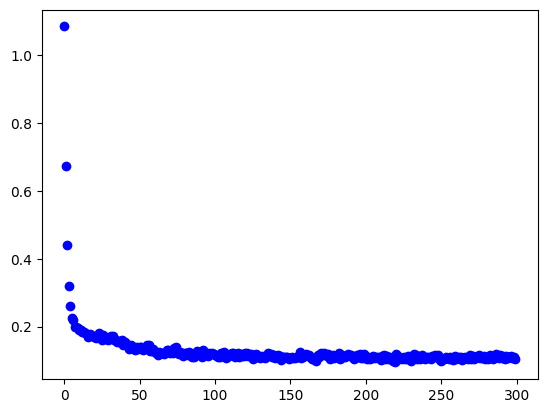

In [6]:
x = diffusion.train(epochs=epochs, 
                    data_loader=data_loader, 
                    loss_function=nn.MSELoss(),
                    optimizer=optimizer, 
                    lr_scheduler=scheduler, 
                    gradient_accum=conf["model"].gradient_accum,
                    checkpoint_freq=checkpoint_freq, 
                    model_path=full_model_path, 
                    start_epoch=start_epoch,
                    patience=100
                )
scatter_plot(x)